In [19]:
 !pip install pennylane pennylane-lightning pennylane-lightning[gpu] --upgrade
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [20]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


<ipython-input-20-c943086f05a9>:34: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')
<ipython-input-20-c943086f05a9>:45: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  gpu_backend = xla_bridge.get_backend('gpu')


# Load the Data

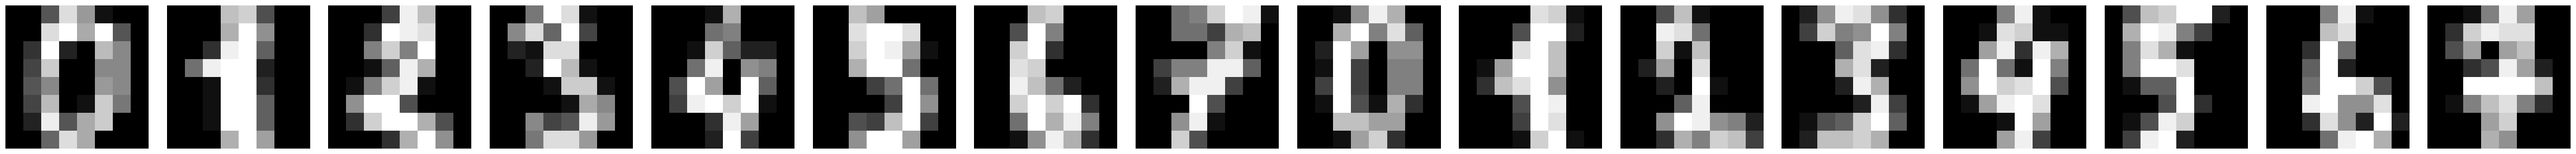

In [21]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]
labels = labels[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]

fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(16*3,3))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8, 8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [22]:
# def load_digits_data(num_train, num_test, rng):
#     """Return training and testing data of digits dataset."""
#     digits = datasets.load_digits()
#     features, labels = digits.data, digits.target

#     features = features[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]
#     labels = labels[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]

#     # rescale data
#     features = features / 16.0
#     # reshape
#     features = features.reshape(-1, 8, 8)
#     # Transform into a Hermitian matrix
#     features = np.array([(img+img.T)/2 for img in features])

#     # subsample train and test split
#     train_indices = rng.choice(len(labels), num_train, replace=False)
#     test_indices = rng.choice(
#         np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
#     )

#     x_train, y_train = features[train_indices], labels[train_indices]
#     x_test, y_test = features[test_indices], labels[test_indices]

#     return (
#         jnp.asarray(x_train),
#         jnp.asarray(y_train),
#         jnp.asarray(x_test),
#         jnp.asarray(y_test),
#     )

def load_digits_data(num_train, num_val, num_test, rng):
    """Return training, validation, and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # Filter out specific digit classes
    mask = (labels >= 0) & (labels <= 7)
    features, labels = features[mask], labels[mask]

    # Rescale data
    features = features / 16.0
    # Reshape
    features = features.reshape(-1, 8, 8)
    # Transform into Hermitian matrices
    features = np.array([(img + img.T) / 2 for img in features])

    # Randomly select indices for train, validation, and test sets
    all_indices = np.arange(len(labels))
    train_indices = rng.choice(all_indices, num_train, replace=False)
    remaining_indices = np.setdiff1d(all_indices, train_indices)

    val_indices = rng.choice(remaining_indices, num_val, replace=False)
    test_indices = np.setdiff1d(remaining_indices, val_indices)

    # Create datasets
    x_train, y_train = features[train_indices], labels[train_indices]
    x_val, y_val = features[val_indices], labels[val_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_val),
        jnp.asarray(y_val),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )


# Embed the Entire Image as Hermitian Operators


For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

This can be achieved via `jax.scipy.linalg.expm`, since `Pennylane` doesn't support batching arbitrary Hermitian operators.

In [23]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==8 and img.shape[-2] == 8, f"The shape of the image must be 8 by 8, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2,
        10
        )
    )

[[ 0.52280899-0.05345201j -0.02012155-0.26802134j -0.01370825+0.09338635j
  -0.2928303 -0.26538394j -0.18970313-0.06420587j  0.2587725 +0.22512408j
   0.19907107-0.16207312j -0.51112755-0.03980056j]
 [-0.02012155-0.26802134j  0.53214286+0.21277722j -0.12639032+0.12245572j
   0.05908119-0.15241347j -0.27790381+0.05520424j  0.0465508 -0.4960972j
   0.18444435-0.32981774j  0.04401798-0.26138985j]
 [-0.01370825+0.09338635j -0.12639032+0.12245572j  0.40941461-0.70503717j
   0.06773457-0.26724076j  0.04424185+0.24340596j -0.05640243-0.02605337j
   0.16318621-0.35578976j -0.03296604-0.00715265j]
 [-0.2928303 -0.26538394j  0.05908119-0.15241347j  0.06773457-0.26724076j
   0.31491764-0.16401045j -0.06864561-0.19646311j  0.42094601-0.06673045j
  -0.37334171+0.31789562j -0.3377229 -0.18859031j]
 [-0.18970313-0.06420587j -0.27790381+0.05520424j  0.04424185+0.24340596j
  -0.06864561-0.19646311j  0.66624915-0.35876976j  0.02846178-0.25246009j
   0.15392837-0.24798376j -0.16901028-0.15554525j]
 [ 0.2

## The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{SU4Layers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 3}
$$


In [24]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

observables_8_dim = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      basis_state = tensor_product(*[ket[i], ket[j], ket[k]])
      idx = int(i+j+k, 2)
      observables_8_dim[idx] = jnp.outer(basis_state, basis_state)

print(pauli_words_su4.keys())
test_params = jnp.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
print(
    jnp.einsum(
        "i, ijk -> jk",
        test_params,
        jnp.asarray(list(pauli_words_su4.values()))
    )
)

dict_keys(['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'])
[[ 30. +0.j  14.-16.j  11.-19.j  -5.-15.j]
 [ 14.+16.j  -6. +0.j  15. -3.j  -3. +3.j]
 [ 11.+19.j  15. +3.j -24. +0.j -12.+12.j]
 [ -5.+15.j  -3. -3.j -12.-12.j   0. +0.j]]


In [25]:
def su4_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk -> jk", params, jnp.asarray(list(pauli_words_su4.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[15], key=jrng_key)
print(su4_op(test_params))
print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su4_op(test_params))),
        su4_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su4_op(test_params),
        jnp.transpose(jnp.conjugate(su4_op(test_params)))
    )
)

[[ 0.18175111+0.14237464j -0.19109383+0.13848737j -0.75200203+0.33751301j
   0.11916688+0.44427193j]
 [ 0.34991553+0.1286837j   0.6067486 -0.02543435j  0.01445637-0.40064771j
   0.50409921+0.27814613j]
 [-0.1659981 -0.3426707j  -0.52691953-0.23243043j  0.27301896-0.17265138j
   0.39882079+0.50985042j]
 [-0.72090804+0.37816483j  0.29208795-0.39815847j -0.0471504 +0.23082313j
   0.14572205+0.12922858j]]
[[ 1.00000000e+00+1.81701793e-17j -2.17690136e-16+1.44718640e-16j
  -1.97497862e-16+2.03006957e-16j  6.60316545e-17-1.11555849e-16j]
 [-2.17690136e-16-1.44271312e-16j  1.00000000e+00+1.08735876e-17j
  -1.91627223e-16+4.85513313e-16j -2.39153754e-16-2.52312274e-16j]
 [-1.97497862e-16-2.01870302e-16j -1.91627223e-16-4.77796251e-16j
   1.00000000e+00+2.63288753e-18j -3.05125821e-16-3.12503901e-16j]
 [ 6.60316545e-17+1.13308790e-16j -2.39153754e-16+2.65372088e-16j
  -3.05125821e-16+3.38679491e-16j  1.00000000e+00+2.41740471e-19j]]
[[ 1.00000000e+00+4.44992099e-18j  5.31968585e-16+8.38337340e-

In [26]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

In [27]:
def su4_layer_3q(
    params:jnp.ndarray
):
  """
  A three-qubit parameterized layer
  made up by two su4 gates
  one on qubit pair (1,2)
  the other one on (2,3)
  """
  first = tensor_product(
      su4_op(params[:15]),
      multi_qubit_identity(1)
  )
  second = tensor_product(
      multi_qubit_identity(1),
      su4_op(params[:15])
  )

  return jnp.dot(second, first)


def qnn_hamevo(
    su4_params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for su4 gates
  and output an array of 8 elements representing classification logits
  """
  n_layers = len(su4_params)//30

  state = tensor_product(ket['+'], ket['+'], ket['+'])

  for i in range(n_layers):
    state = jnp.dot(img_hermitian_evolve(img, t[i]), state)
    state = jnp.dot(
        su4_layer_3q(su4_params[30*i: 30*(i+1)]),
        state
    )

  return vmap_measure_sv(state, jnp.asarray(observables_8_dim))

print(
    qnn_hamevo(
        jax.random.normal(shape=[30*30], key=jrng_key),
        jax.random.normal(shape=[30], key=jrng_key),
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2
    )
)
print(jnp.sum(
    qnn_hamevo(
        jax.random.normal(shape=[30*30], key=jrng_key),
        jax.random.normal(shape=[30], key=jrng_key),
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2
    )
))

[0.05179166 0.06989755 0.12196543 0.22654106 0.11609438 0.19215207
 0.11029855 0.1112593 ]
0.9999999999999982


In [28]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(cost, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [29]:
N_LAYERS = 15

def init_weights_random():
    print("RANDOM INIT")
    return jax.random.normal(shape=[30*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_LAYERS], key=jrng_key)


def init_weights_beta(alpha=0.5, beta=2.0):
    print("BETA")
    # Initialize weights with a Beta distribution skewed towards 0
    weights = jax.random.beta(jrng_key, alpha, beta, shape=[30*N_LAYERS])
    biases = jax.random.beta(jrng_key, alpha, beta, shape=[N_LAYERS])
    return weights, biases


In [30]:
import pandas as pd
import os


def save_weights_to_csv(weights, biases, epoch, file_name='weights.csv'):
    """Saves the weights and biases to a CSV file."""
    # Convert weights and biases to a flat list
    weight_list = weights.flatten().tolist()
    bias_list = biases.flatten().tolist()

    # Create a dictionary to store the weights and biases with epoch
    data = {'epoch': [epoch], 'weights': [weight_list], 'biases': [bias_list]}

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Check if the file exists before appending
    if not os.path.isfile(file_name):
        # If the file does not exist, create it with a header
        df.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # If the file exists, append the new data without a header
        df.to_csv(file_name, mode='a', header=False, index=False)

def load_weights_and_biases_from_csv(file_name):
    # Load the weights DataFrame
    weights_data = pd.read_csv(file_name)

    # Get the last epoch's weights and biases
    last_epoch = weights_data.iloc[-1]  # Get the last row
    weights = np.array(eval(last_epoch['weights']))  # Convert string representation back to array
    biases = np.array(eval(last_epoch['biases']))  # Convert string representation back to array

    return weights, biases

In [31]:
import numpy as np
import pandas as pd
import time
import optax
import jax.numpy as jnp

def batch_data(data, targets, batch_size):
    N = data.shape[0]
    for i in range(0, N, batch_size):
        yield data[i:i + batch_size], targets[i:i + batch_size]


def train_qnn(n_train, n_val, n_test, n_epochs, batch_size=100):
    """
    Train and evaluate QNN using both random and beta initializations.

    Args:
        n_train  (int): number of training examples
        n_val    (int): number of validation examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs

    Returns:
        dict, dict, x_test, y_test: Training metrics for random and beta initializations, and test data.
    """
    # Load data once before starting the loops
    x_train, y_train, x_val, y_val, x_test, y_test = load_digits_data(n_train, n_val, n_test, rng)

    def train_model(init_weights_func, file_name):
        """Train the model using the given initialization function."""
        # Initialize weights using the specified function
        weight, t = init_weights_func()
        optimizer = optax.adam(learning_rate=0.1)
        opt_state = optimizer.init((weight, t))

        # Data containers for tracking progress
        train_cost_epochs, val_cost_epochs = [], []
        train_acc_epochs, val_acc_epochs = [], []

        for step in range(n_epochs):
            epoch_start = time.time()
            print(f"Training at Epoch {step+1}/{n_epochs} with {file_name} initialization...")

            # Batching for training
            batch_cost, batch_acc = [], []
            for batch_id, (x, y) in enumerate(batch_data(x_train, y_train, batch_size)):
                batch_start = time.time()

                # Compute cost and gradients
                train_cost_batch, grad_circuit = value_and_grad(weight, t, x, y)
                updates, opt_state = optimizer.update(grad_circuit, opt_state, (weight, t))
                weight, t = optax.apply_updates((weight, t), updates)
                batch_cost.append(train_cost_batch)

                # Compute accuracy on training batch
                train_acc_batch = compute_accuracy(weight, t, x, y)
                batch_acc.append(train_acc_batch)

                print(f"Epoch {step+1}/{n_epochs}, Batch {batch_id+1}, Cost {train_cost_batch}, Acc {train_acc_batch}. Time {time.time()-batch_start}")

            # Record training metrics for the epoch
            train_cost_epochs.append(np.mean(batch_cost))
            train_acc_epochs.append(np.mean(batch_acc))

            # Validation metrics
            val_out = compute_out(weight, t, x_val, y_val)
            val_pred = jnp.argmax(val_out, axis=1)
            val_acc = jnp.sum(jnp.array(val_pred == y_val).astype(int)) / len(y_val)
            val_acc_epochs.append(val_acc)
            val_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))
            val_cost_epochs.append(val_cost)

            print(f"Epoch {step+1}/{n_epochs}, Train Cost: {np.mean(batch_cost)}, Train Acc: {np.mean(batch_acc)}, Val Cost: {val_cost}, Val Acc: {val_acc}")
            print("=-=" * 10)

        # Final evaluation on the test set
        test_out = compute_out(weight, t, x_test, y_test)
        test_pred = jnp.argmax(test_out, axis=1)
        test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(y_test)
        test_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))

        # Save the final weights to a CSV file
        save_weights_to_csv(weight, t,n_epochs, file_name=file_name)

        # Return the results as a dictionary
        return dict(
            n_train=[n_train] * n_epochs,
            step=np.arange(1, n_epochs + 1, dtype=int),
            train_cost=train_cost_epochs,
            train_acc=train_acc_epochs,
            val_cost=val_cost_epochs,
            val_acc=val_acc_epochs,
            test_cost=test_cost,
            test_acc=test_acc
        )

    # Loop 1: Random Initialization
    results_random = train_model(init_weights_random, 'random_weights.csv')

    # Loop 2: Beta Initialization
    results_beta = train_model(init_weights_beta, 'beta_weights.csv')

    # Return both dictionaries along with x_test and y_test
    return results_random, results_beta, x_test, y_test



In [14]:
# n_test = 100
# n_epochs = 500
# n_reps = 20
# batch_size = 2000

# train_sizes = [1200]

# def run_iterations(n_train):
#     results_df = pd.DataFrame(
#         columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
#     )

#     for _ in range(n_reps):
#         results = train_qnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs, batch_size=batch_size)
#         results_df = pd.concat(
#             [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
#         )

#     return results_df

# results_df = run_iterations(n_train=1200)
# #for n_train in train_sizes[1:]:
# #    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])


n_test = 130
n_val = 130  # Approx. 10% of the data for validation
n_epochs = 500
n_reps = 7
batch_size = 2000

train_sizes = [1040]

def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "val_acc", "val_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        # results,xT,yT = train_qnn(n_train=n_train, n_val=n_val, n_test=n_test, n_epochs=n_epochs, batch_size=batch_size)
        results_random, results_beta, x_test, y_test = train_qnn(n_train=1040, n_val=n_val, n_test=n_test, n_epochs=n_epochs, batch_size=batch_size)
        results_random_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results_random)], axis=0, ignore_index=True
        )
        results_beta_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results_beta)], axis=0, ignore_index=True
        )

    return results_random_df,results_beta_df,x_test,y_test

# Run the function for specified train sizes
results_random_df,results_beta_df,xT,yT = run_iterations(n_train=1040)
# for n_train in train_sizes[1:]:
#     results_df = pd.concat([results_df, run_iterations(n_train=n_train)])


RANDOM INIT
Training at Epoch 1/500 with random_weights.csv initialization...


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Epoch 1/500, Batch 1, Cost 2.0891533626522354, Acc 0.20192307692307693. Time 68.25127124786377
Epoch 1/500, Train Cost: 2.0891533626522354, Train Acc: 0.20192307692307693, Val Cost: 2.0744384856729257, Val Acc: 0.14615384615384616
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.06053338031287, Acc 0.13846153846153847. Time 0.9137182235717773
Epoch 2/500, Train Cost: 2.06053338031287, Train Acc: 0.13846153846153847, Val Cost: 2.0749022667998966, Val Acc: 0.13846153846153847
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.081303207233039, Acc 0.14134615384615384. Time 0.754671573638916
Epoch 3/500, Train Cost: 2.081303207233039, Train Acc: 0.14134615384615384, Val Cost: 2.0447048748265337, Val Acc: 0.2
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 1, Cost 2.06870089

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.086973050143845, Acc 0.1673076923076923. Time 0.7738850116729736
Epoch 1/500, Train Cost: 2.086973050143845, Train Acc: 0.1673076923076923, Val Cost: 2.0479165483117563, Val Acc: 0.23076923076923078
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.055773714391346, Acc 0.1. Time 0.7763733863830566
Epoch 2/500, Train Cost: 2.055773714391346, Train Acc: 0.1, Val Cost: 2.092557839351216, Val Acc: 0.1
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0891154458285577, Acc 0.2826923076923077. Time 0.7561438083648682
Epoch 3/500, Train Cost: 2.0891154458285577, Train Acc: 0.2826923076923077, Val Cost: 2.0225651886783926, Val Acc: 0.3
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 1, Cost 2.022818489594759, Acc 0.4346153846153846. Time 0.754883050

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.086939441568333, Acc 0.17596153846153847. Time 0.7571704387664795
Epoch 1/500, Train Cost: 2.086939441568333, Train Acc: 0.17596153846153847, Val Cost: 2.0672736659209643, Val Acc: 0.18461538461538463
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.0695717052642864, Acc 0.17692307692307693. Time 0.7614498138427734
Epoch 2/500, Train Cost: 2.0695717052642864, Train Acc: 0.17692307692307693, Val Cost: 2.0584460484364486, Val Acc: 0.18461538461538463
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0697987273378793, Acc 0.21346153846153845. Time 0.7563648223876953
Epoch 3/500, Train Cost: 2.0697987273378793, Train Acc: 0.21346153846153845, Val Cost: 2.0517071047552538, Val Acc: 0.2
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 1, Cost 2.04

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.0877867899379496, Acc 0.14615384615384616. Time 0.7630577087402344
Epoch 1/500, Train Cost: 2.0877867899379496, Train Acc: 0.14615384615384616, Val Cost: 2.075670827357328, Val Acc: 0.12307692307692308
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.059700391008219, Acc 0.17403846153846153. Time 0.7549698352813721
Epoch 2/500, Train Cost: 2.059700391008219, Train Acc: 0.17403846153846153, Val Cost: 2.066380131117837, Val Acc: 0.17692307692307693
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0697740607402517, Acc 0.24326923076923077. Time 0.7564599514007568
Epoch 3/500, Train Cost: 2.0697740607402517, Train Acc: 0.24326923076923077, Val Cost: 2.0218809233874833, Val Acc: 0.24615384615384617
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batc

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.0889527917109287, Acc 0.19903846153846153. Time 0.7550890445709229
Epoch 1/500, Train Cost: 2.0889527917109287, Train Acc: 0.19903846153846153, Val Cost: 2.04402400776471, Val Acc: 0.19230769230769232
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.046062458389045, Acc 0.1076923076923077. Time 0.7600729465484619
Epoch 2/500, Train Cost: 2.046062458389045, Train Acc: 0.1076923076923077, Val Cost: 2.0904976708642247, Val Acc: 0.13076923076923078
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0921610777816824, Acc 0.20384615384615384. Time 0.7759099006652832
Epoch 3/500, Train Cost: 2.0921610777816824, Train Acc: 0.20384615384615384, Val Cost: 2.0548039628151296, Val Acc: 0.2153846153846154
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 1

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.088002686611142, Acc 0.13076923076923078. Time 0.7614090442657471
Epoch 1/500, Train Cost: 2.088002686611142, Train Acc: 0.13076923076923078, Val Cost: 2.0741663470735965, Val Acc: 0.12307692307692308
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.068501931343129, Acc 0.16538461538461538. Time 0.7645747661590576
Epoch 2/500, Train Cost: 2.068501931343129, Train Acc: 0.16538461538461538, Val Cost: 2.06592213674199, Val Acc: 0.16153846153846155
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0684142485888235, Acc 0.28557692307692306. Time 0.7583889961242676
Epoch 3/500, Train Cost: 2.0684142485888235, Train Acc: 0.28557692307692306, Val Cost: 2.0455459090469827, Val Acc: 0.2692307692307692
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 1

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Epoch 1/500, Batch 1, Cost 2.0873987109895027, Acc 0.1548076923076923. Time 0.7756156921386719
Epoch 1/500, Train Cost: 2.0873987109895027, Train Acc: 0.1548076923076923, Val Cost: 2.0698092093050207, Val Acc: 0.12307692307692308
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500 with random_weights.csv initialization...
Epoch 2/500, Batch 1, Cost 2.061963417959916, Acc 0.12211538461538461. Time 0.7758464813232422
Epoch 2/500, Train Cost: 2.061963417959916, Train Acc: 0.12211538461538461, Val Cost: 2.0860353503148414, Val Acc: 0.13076923076923078
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500 with random_weights.csv initialization...
Epoch 3/500, Batch 1, Cost 2.0810834663426023, Acc 0.1519230769230769. Time 0.7598209381103516
Epoch 3/500, Train Cost: 2.0810834663426023, Train Acc: 0.1519230769230769, Val Cost: 2.0612145350244715, Val Acc: 0.14615384615384616
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500 with random_weights.csv initialization...
Epoch 4/500, Batch 

<ipython-input-14-21099992ac75>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-14-21099992ac75>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


In [15]:
#94 random
#96 beta


print(results_random_df.iloc[-1])
print(results_beta_df.iloc[-1])

train_acc               0.953846
train_cost              1.546944
val_acc       0.9615384615384616
val_cost      1.5673656995730907
test_acc      0.9560439560439561
test_cost     1.5559949075800057
step                         500
n_train                     1040
Name: 499, dtype: object
train_acc               0.967308
train_cost              1.520276
val_acc       0.9615384615384616
val_cost       1.551218239836168
test_acc      0.9560439560439561
test_cost     1.5366118035748395
step                         500
n_train                     1040
Name: 499, dtype: object


Alpha: 0.0
Alpha: 0.0
Accuracy: 0.9560439560439561, Cost: 1.5559949075800057
Alpha: 0.1
Alpha: 0.1
Accuracy: 0.9633699633699634, Cost: 1.5537990551693417
Alpha: 0.2
Alpha: 0.2
Accuracy: 0.9597069597069597, Cost: 1.551660026175263
Alpha: 0.30000000000000004
Alpha: 0.30000000000000004
Accuracy: 0.967032967032967, Cost: 1.5495779764783566
Alpha: 0.4
Alpha: 0.4
Accuracy: 0.9743589743589743, Cost: 1.5475530605567847
Alpha: 0.5
Alpha: 0.5
Accuracy: 0.967032967032967, Cost: 1.5455854313278585
Alpha: 0.6
Alpha: 0.6
Accuracy: 0.9633699633699634, Cost: 1.5436752399662255
Alpha: 0.7
Alpha: 0.7
Accuracy: 0.9597069597069597, Cost: 1.5418226356988274
Alpha: 0.7999999999999999
Alpha: 0.7999999999999999
Accuracy: 0.9560439560439561, Cost: 1.5400277655770036
Alpha: 0.8999999999999999
Alpha: 0.8999999999999999
Accuracy: 0.9597069597069597, Cost: 1.5382907742263088
Alpha: 0.9999999999999999
Alpha: 0.9999999999999999
Accuracy: 0.9560439560439561, Cost: 1.5366118035748395
    Alpha            Accuracy     

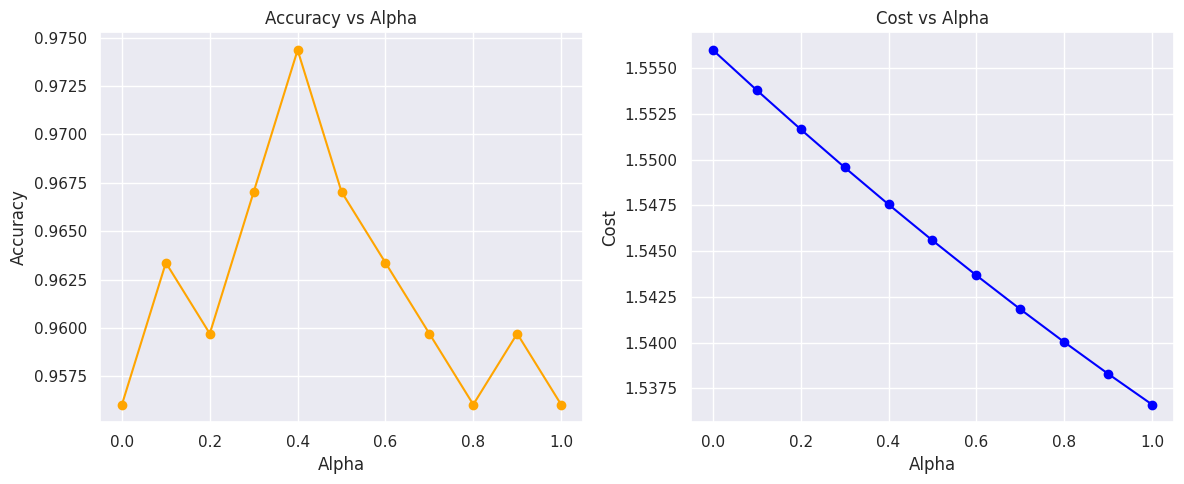

In [16]:
import pandas as pd
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

def ensemble_predict(test_features, file1='beta_weights.csv', file2='random_weights.csv', alpha=0.5):
    """Performs ensemble prediction on the test dataset using two models."""
    print(f"Alpha: {alpha}")

    # Load weights and biases from CSV files
    weight1, bias1 = load_weights_and_biases_from_csv(file1)
    weight2, bias2 = load_weights_and_biases_from_csv(file2)

    # Compute outputs from both models
    output1 = compute_out(weight1, bias1, test_features, None)  # No labels needed for prediction
    output2 = compute_out(weight2, bias2, test_features, None)

    # Compute ensemble output
    ensemble_output = alpha * output1 + (1 - alpha) * output2

    return ensemble_output

def evaluate_ensemble(test_features, test_labels):
    """Evaluate the ensemble on the test dataset."""
    # Initialize alpha
    alpha = 0.0

    # Initialize a list to store results
    results = []  # To store results for each step

    # Loop to adjust alpha
    while alpha <= 1.0:
        print(f"Alpha: {alpha}")
        ensemble_output = ensemble_predict(test_features, file1='beta_weights.csv', file2='random_weights.csv', alpha=alpha)
        ensemble_pred = jnp.argmax(ensemble_output, axis=1)

        # Calculate accuracy
        ensemble_accuracy = jnp.sum(jnp.array(ensemble_pred == test_labels).astype(int)) / len(test_labels)

        # Calculate cost
        ensemble_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(ensemble_output, test_labels))
        print(f"Accuracy: {ensemble_accuracy}, Cost: {ensemble_cost}")

        # Store the results
        results.append((alpha, ensemble_accuracy, ensemble_cost))

        # Increment alpha
        alpha += 0.1

    # Create a DataFrame from results
    results_df = pd.DataFrame(results, columns=["Alpha", "Accuracy", "Cost"])
    return results_df

# Evaluate ensemble and get results DataFrame
ensemble_results_df = evaluate_ensemble(xT, yT)

# Print the results DataFrame
print(ensemble_results_df)

# Data from the new table
alpha_new = ensemble_results_df['Alpha']
accuracy_new = ensemble_results_df['Accuracy']
cost_new = ensemble_results_df['Cost']

# Plot Accuracy vs Alpha
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alpha_new, accuracy_new, marker='o', linestyle='-', color='orange')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Cost vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alpha_new, cost_new, marker='o', linestyle='-', color='blue')
plt.title('Cost vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Cost')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


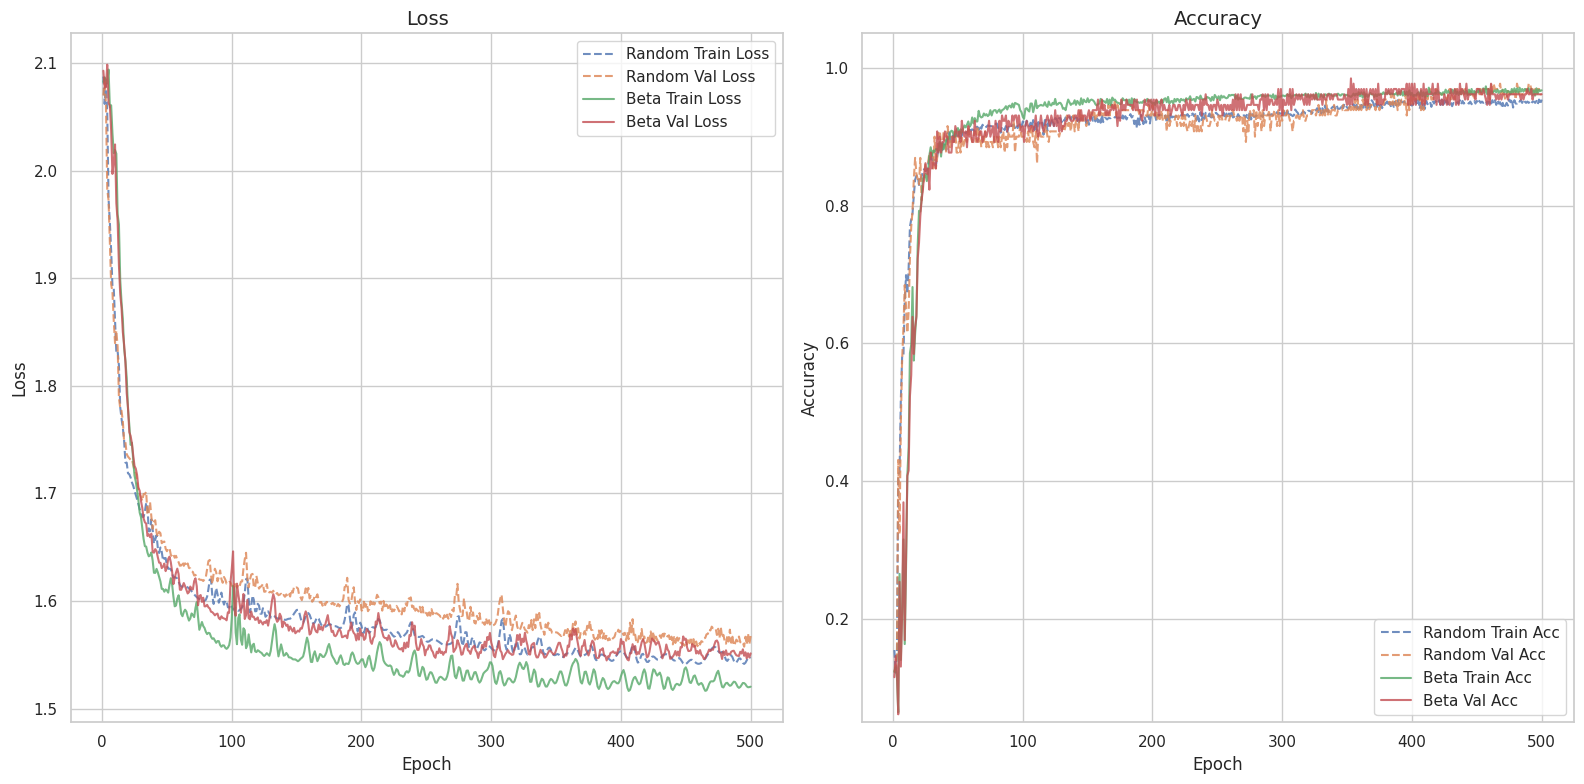

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data for plotting (mean and std per epoch)
df_random_agg = results_random_df.groupby(["step"]).agg(["mean", "std"]).reset_index()
df_beta_agg = results_beta_df.groupby(["step"]).agg(["mean", "std"]).reset_index()

sns.set_style("whitegrid")
colors = sns.color_palette()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))  # 1 row, 2 columns for 2 graphs (Loss, Accuracy)
axes = axes.flatten()  # Flatten for easy indexing

# Titles and axis labels
titles = ["Loss", "Accuracy"]
ylabels = ["Loss", "Accuracy"]

# Plot metrics
for i, (df, label) in enumerate([
    (df_random_agg, "Random"),
    (df_beta_agg, "Beta"),
]):
    # Loss: Train and Validation
    train_loss = df.train_cost["mean"]
    val_loss = df.val_cost["mean"]
    # Accuracy: Train and Validation
    train_acc = df.train_acc["mean"]
    val_acc = df.val_acc["mean"]

    # Loss plot
    axes[0].plot(
        df.step, train_loss,
        label=f"{label} Train Loss",
        linestyle="--" if label == "Random" else "-",
        color=colors[2 * i],  # Unique color
        alpha=0.8
    )
    axes[0].plot(
        df.step, val_loss,
        label=f"{label} Val Loss",
        linestyle="--" if label == "Random" else "-",
        color=colors[2 * i + 1],  # Unique color
        alpha=0.8
    )

    # Accuracy plot
    axes[1].plot(
        df.step, train_acc,
        label=f"{label} Train Acc",
        linestyle="--" if label == "Random" else "-",
        color=colors[2 * i],  # Unique color
        alpha=0.8
    )
    axes[1].plot(
        df.step, val_acc,
        label=f"{label} Val Acc",
        linestyle="--" if label == "Random" else "-",
        color=colors[2 * i + 1],  # Unique color
        alpha=0.8
    )

# Format each subplot
for idx, ax in enumerate(axes):
    ax.set_title(titles[idx], fontsize=14)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabels[idx])
    if idx == 1:  # Accuracy plot
        ax.set_ylim(0.05, 1.05)  # Accuracy typically ranges between 0 and 1
    ax.legend()

plt.tight_layout()
plt.show()


In [18]:
from google.colab import files

# Replace 'your_notebook_name.ipynb' with the actual filename of your notebook
files.download('digits_Final_hopefully.ipynb')


FileNotFoundError: Cannot find file: digits_Final_hopefully.ipynb